In this notebook, we will explore making features by hand for the Home Credit Default Risk dataset

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

#### Function to Convert Data Types

This will help reduce memory usage by using more efficient types for the variables. For example `category` is often a better type than `object` (unless the number of unique categories is close to the number of rows in the dataframe).

In [2]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

## Bureau Data

In [3]:
# Read in bureau
bureau = pd.read_csv('../data/raw/bureau.csv')
bureau = convert_types(bureau, print_info=True)
bureau.head()

Original Memory Usage: 0.23 gb.
New Memory Usage: 0.1 gb.


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [5]:
# Load the training dataframe
train_raw = pd.read_csv('../data/raw/application_train.csv')
train_raw = convert_types(train_raw, print_info=True)
train_raw.head()

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.13 gb.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,True,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,False,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,False,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,False,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,False,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Join to the training dataframe
train = train_raw.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
print("Original Number of Features: ", train_raw.shape[1])
print("New Number of Features: ", train.shape[1])
train.head()

Original Number of Features:  122
New Number of Features:  123


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,True,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,False,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,False,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,False,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,False,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Assessing Usefulness of New Variable with r value
To determine if the new variable is useful, we can calculate the Pearson Correlation Coefficient (r-value) between this variable and the target. This measures the strength of a linear relationship between two variables and ranges from -1 (perfectly negatively linear) to +1 (perfectly positively linear). The r-value is not best measure of the "usefulness" of a new variable, but it can give a first approximation of whether a variable will be helpful to a machine learning model.

In [7]:
# Plots the distribution of a variable colored by the value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # Label the plot
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title(f'{var_name} Distribution')
    plt.legend()
    
    # Print out the correlation
    print(f'The correlation between {var_name} and the TARGET is {corr:.4f}')
    # Print out average values
    print(f'Median value for loan that was not repaid = {avg_not_repaid:.4f}')
    print(f'Median value for loan that was repaid = {avg_repaid:.4f}')


The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid = 0.5460


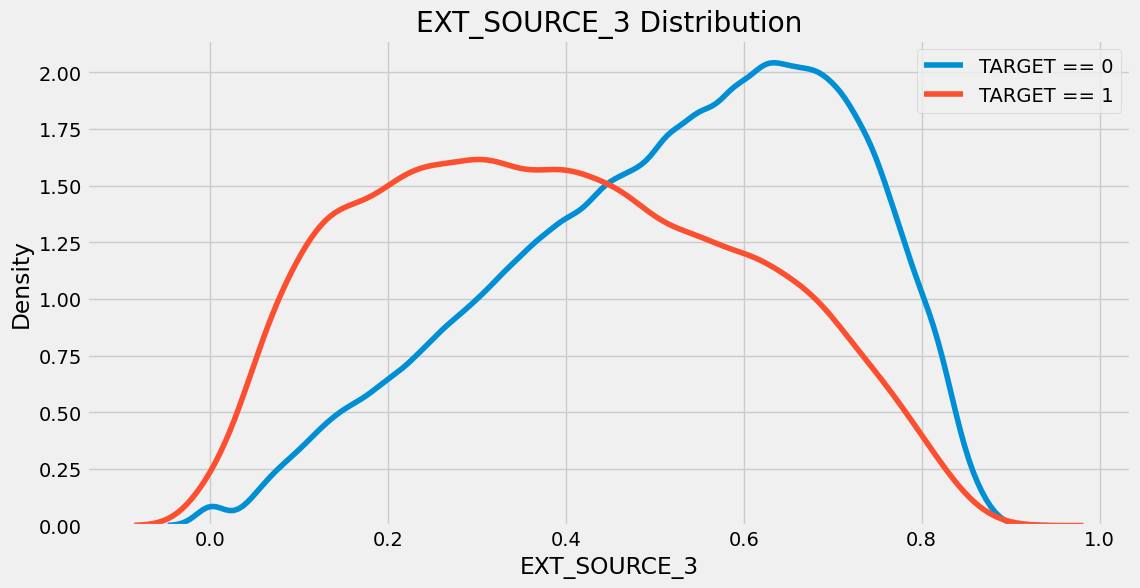

In [8]:
# Example KDE plot
kde_target('EXT_SOURCE_3', train)

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid = 4.0000


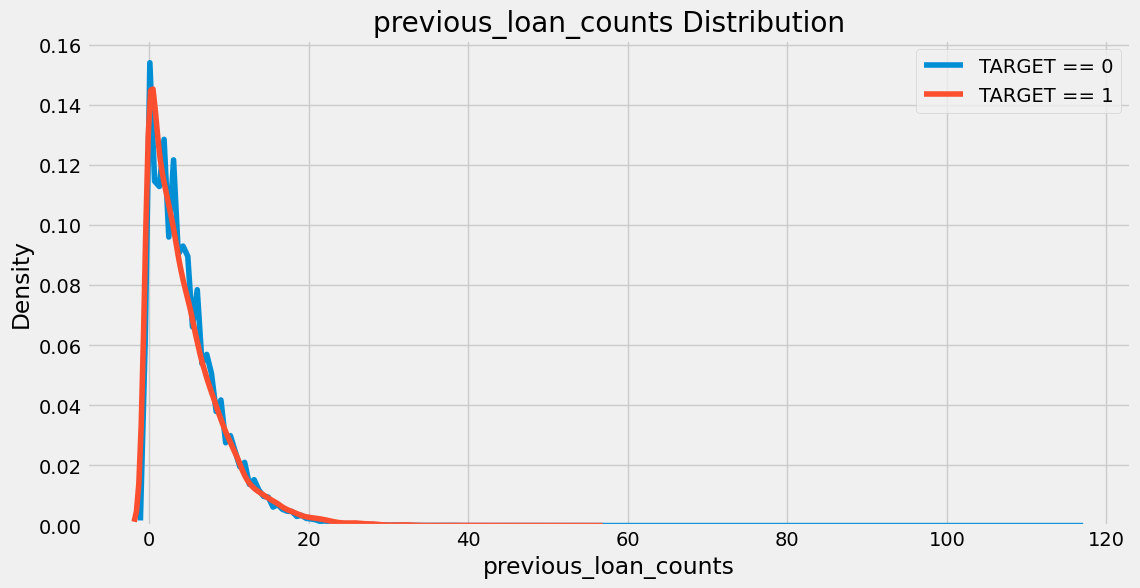

In [9]:
kde_target('previous_loan_counts', train)

From this it's difficult to tell if this variable will be important. The correlation coefficient is extremely weak and there is almost no noticeable difference in the distributions. 

Let's move on to make a few more variables from the bureau dataframe. We will take the mean, min, and max of every numeric column in the bureau dataframe.

### Aggregating Numeric Columns

To account for the numeric information in the `bureau` dataframe, we can compute statistics for all the numeric columns. To do so, we `groupby` the client id, `agg` the grouped dataframe, and merge the result back into the training data. The `agg` function will only calculate the values for the numeric columns where the operation is considered valid. We will stick to using `'mean', 'max', 'min', 'sum'` but any function can be passed in here. We can even write our own function and use it in an `agg` call. 

In [10]:
bureau_numeric = bureau.select_dtypes('number')
bureau_numeric.drop(columns = ['SK_ID_BUREAU'], inplace = True)
bureau_numeric.head()

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN
1,215354,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN
2,215354,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN
3,215354,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN
4,215354,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN


In [11]:
bureau_numeric_agg = bureau_numeric.groupby('SK_ID_CURR').agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_numeric_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357178  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

We need to create new names for each of these columns. The following code makes new names by appending the stat to the name. Here we have to deal with the fact that the dataframe has a multi-level index. I find these confusing and hard to work with, so I try to reduce to a single level index as quickly as possible.

In [12]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_numeric_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_numeric_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

# See how many columns we made
len(columns)

61

In [13]:
bureau_numeric_agg.columns = columns
bureau_numeric_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357178,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### Function for Numeric Aggregations

Let's encapsulate all of the previous work into a function. This will allow us to compute aggregate stats for numeric columns across any dataframe. We will re-use this function when we want to apply the same operations for other dataframes.

In [14]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [15]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
print('New aggregation shape: ', bureau_agg_new.shape)
bureau_agg_new.head()

New aggregation shape:  (305811, 61)


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357178,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [16]:
print('Original shape: ', bureau_numeric_agg.shape)
bureau_numeric_agg.head()

Original shape:  (305811, 61)


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357178,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


If we go through and inspect the values, we do find that they are equivalent. We will be able to reuse this function for calculating numeric stats for other dataframes. Using functions allows for consistent results and decreases the amount of work we have to do in the future!

In [17]:
# Merge with the training data
print('Original shape: ', train.shape)
train = train.merge(bureau_agg_new, on = 'SK_ID_CURR', how = 'left')
print('Training shape: ', train.shape)
train.head()

Original shape:  (307511, 123)
Training shape:  (307511, 183)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,True,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,False,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,False,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,False,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,False,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


In [18]:
# List of new correlations
new_corrs = []

# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    
    # Append the list as a tuple

    new_corrs.append((col, corr))

In [19]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.089728967219981),
 ('bureau_DAYS_CREDIT_min', 0.07524825103010374),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968684),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.055887379843920795),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.053734895601020585),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962580092951),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997309),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115936),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275436796515),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073023),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484667),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.0414036353530601),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632898),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921615996),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332547)]

None of the new variables have a significant correlation with the TARGET. We can look at the KDE plot of the highest correlated variable, `bureau_DAYS_CREDIT_mean`, with the target in  in terms of absolute magnitude correlation. 

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid = -1067.0000


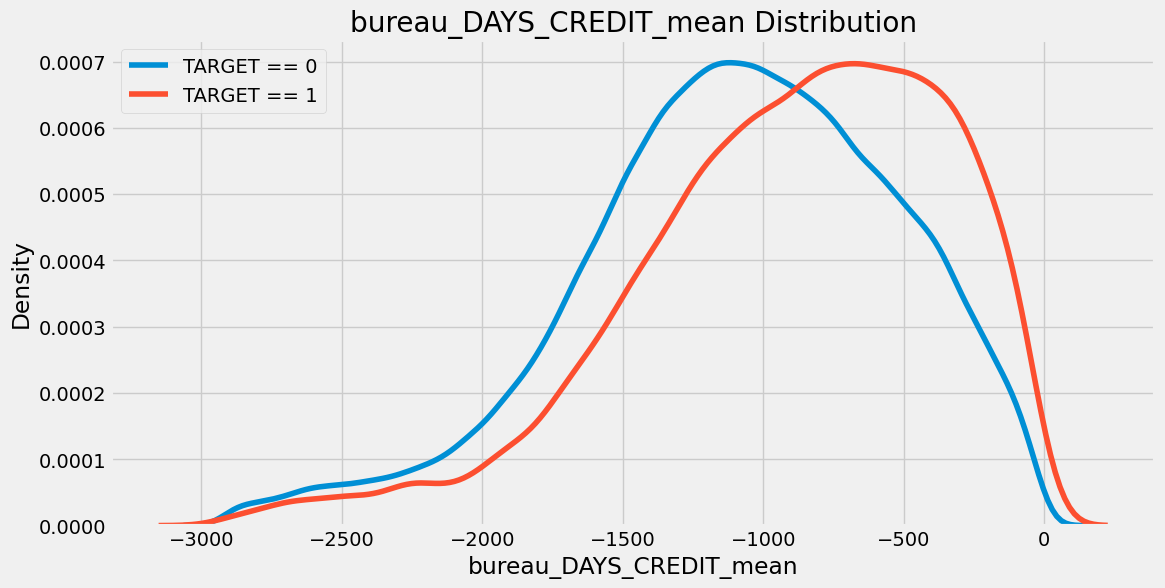

In [20]:
kde_target('bureau_DAYS_CREDIT_mean', train)

The definition of this column is: "How many days before current application did client apply for Credit Bureau credit". My interpretation is this is the number of days that the previous loan was applied for before the application for a loan at Home Credit. Therefore, a larger negative number indicates the loan was further before the current loan application. We see an extremely weak positive relationship between the average of this variable and the target meaning that clients who applied for loans further in the past potentially are more likely to repay loans at Home Credit. With a correlation this weak though, it is just as likely to be noise as a signal. 


### Correlation Function
Before we move on, we can also make the code to calculate correlations with the target into a function.

In [21]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

### Categorical Variables
Now we move from the numeric columns to the categorical columns. These are discrete string variables, so we cannot just calculate statistics such as mean and max which only work with numeric variables. Instead, we will rely on calculating value counts of each category within each categorical variable.

First we one-hot encode a dataframe with only the categorical columns (dtype == 'category').

In [22]:
bureau.dtypes

SK_ID_CURR                   int32
SK_ID_BUREAU                 int32
CREDIT_ACTIVE             category
CREDIT_CURRENCY           category
DAYS_CREDIT                  int32
CREDIT_DAY_OVERDUE           int32
DAYS_CREDIT_ENDDATE        float32
DAYS_ENDDATE_FACT          float32
AMT_CREDIT_MAX_OVERDUE     float32
CNT_CREDIT_PROLONG           int32
AMT_CREDIT_SUM             float32
AMT_CREDIT_SUM_DEBT        float32
AMT_CREDIT_SUM_LIMIT       float32
AMT_CREDIT_SUM_OVERDUE     float32
CREDIT_TYPE               category
DAYS_CREDIT_UPDATE           int32
AMT_ANNUITY                float32
dtype: object

In [23]:
categorical = pd.get_dummies(bureau.select_dtypes('category'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354
1,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354
2,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354
3,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354
4,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354


In [24]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

We can use a similar function as before to rename the columns. Again, we have to deal with the multi-level index for the columns. We iterate through the first level (level 0) which is the name of the categorical variable appended with the value of the category (from one-hot encoding). Then we iterate stats we calculated for each client. We will rename the column with the level 0 name appended with the stat. As an example, the column with CREDIT_ACTIVE_Active as level 0 and sum as level 1 will become CREDIT_ACTIVE_Active_count.

In [25]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Function to Handle Categorical Variables
To make the code more efficient, we can now write a function to handle the categorical variables for us. This will take the same form as the agg_numeric function in that it accepts a dataframe and a grouping variable. Then it will calculate the counts and normalized counts of each category for all categorical variables in the dataframe.

In [26]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [27]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
print('New bureau shape: ', bureau_counts.shape)
bureau_counts.head()

New bureau shape:  (305811, 46)


,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [28]:
print('Original shape: ', categorical_grouped.shape)
categorical_grouped.head()

Original shape:  (305811, 46)


,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [29]:
# Merge with the training data
print('Original shape: ', train.shape)

Original shape:  (307511, 183)


In [30]:
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
print('Training shape: ', train.shape)
train.head()

Training shape:  (307511, 229)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,True,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,False,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,False,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,False,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,False,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Applying Operations to another dataframe
We will now turn to the bureau balance dataframe. This dataframe has monthly information about each client's previous loan(s) with other financial institutions. Instead of grouping this dataframe by the SK_ID_CURR which is the client id, we will first group the dataframe by the SK_ID_BUREAU which is the id of the previous loan. This will give us one row of the dataframe for each loan. Then, we can group by the SK_ID_CURR and calculate the aggregations across the loans of each client. The final result will be a dataframe with one row for each client, with stats calculated for their loans.

In [31]:
# Read in bureau balance
bureau_balance = pd.read_csv('../data/raw/bureau_balance.csv')
bureau_balance = convert_types(bureau_balance, print_info=True)
bureau_balance.head()

Original Memory Usage: 0.66 gb.
New Memory Usage: 0.25 gb.


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


First, we can calculate the value counts of each status for each loan.

In [32]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


Now we can handle the one numeric column. The MONTHS_BALANCE column has the "months of balance relative to application date." For now, we can just calculate the same aggregation statistics as previously.

In [33]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


The above dataframes have the calculations done on each loan. Now we need to aggregate these for each client. We can do this by merging the dataframes together first and then since all the variables are numeric, we just need to aggregate the statistics again, this time grouping by the SK_ID_CURR.

In [34]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [35]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41,4,0.254545,1.000000,0.0,1.018182


To recap, for the bureau_balance dataframe we:

- Calculated numeric stats grouping by each loan
- Made value counts of each categorical variable grouping by loan
- Merged the stats and the value counts on the loans
- Calculated numeric stats for the resulting dataframe grouping by the client id

The final resulting dataframe has one row for each client, with statistics calculated for all of their loans with monthly balance information.

### Putting the Functions Together
We now have all the pieces in place to take the information from the previous loans at other institutions and the monthly payments information about these loans and put them into the main training dataframe. Let's do a reset of all the variables and then use the functions we built to do this from the ground up. This demonstrate the benefit of using functions for repeatable workflows!

In [36]:
# Free up memory by deleting old objects
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_numeric_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

286

In [37]:
# Read in new copies of all the dataframes
train = pd.read_csv('../data/raw/application_train.csv')
bureau = pd.read_csv('../data/raw/bureau.csv')
bureau_balance = pd.read_csv('../data/raw/bureau_balance.csv')

# Apply previous preprocessing
train = convert_types(train)
bureau = convert_types(bureau)
bureau_balance = convert_types(bureau_balance)


#### Counts of Bureau Dataframe

In [38]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


#### Aggregated Stats of Bureau Dataframe

In [39]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357178,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


#### Value counts of Bureau Balance dataframe by loan

In [40]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


#### Aggregated stats of Bureau Balance dataframe by loan

In [41]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


#### Aggregated Stats of Bureau Balance by Client

In [42]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

#### Insert Computed Features into Training Data

In [43]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [44]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


#### Bureau Data Feature Engineering Outcomes
After all that work, now we want to take a look at the variables we have created. We can look at the percentage of missing values, the correlations of variables with the target, and also the correlation of variables with the other variables. The correlations between variables can show if we have collinear varibles, that is, variables that are highly correlated with one another. Often, we want to remove one in a pair of collinear variables because having both variables would be redundant. We can also use the percentage of missing values to remove features with a substantial majority of values that are not present. Feature selection will be an important focus going forward, because reducing the number of features can help the model learn during training and also generalize better to the testing data. The "curse of dimensionality" is the name given to the issues caused by having too many features (too high of a dimension). As the number of variables increases, the number of datapoints needed to learn the relationship between these variables and the target value increases exponentially.

Feature selection is the process of removing variables to help our model to learn and generalize better to the testing set. The objective is to remove useless/redundant variables while preserving those that are useful. There are a number of tools we can use for this process, but in this notebook we will stick to removing columns with a high percentage of missing values and variables that have a high correlation with one another. Later we can look at using the feature importances returned from models such as the Gradient Boosting Machine or Random Forest to perform feature selection.

### Missing Values

In [45]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [46]:
missing_train = missing_values_table(train)
missing_train.head(20)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


In [47]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

We see there are a number of columns with a high percentage of missing values.
>
Before we remove the missing values, we will find the missing value percentages in the testing data. We'll then remove any columns with greater than 90% missing values in either the training or testing data. Let's now read in the testing data, perform the same operations, and look at the missing values in the testing data. We already have calculated all the counts and aggregation statistics, so we only need to merge the testing data with the appropriate data.

In [48]:
# Read in the test dataframe
test = pd.read_csv('../data/raw/application_test.csv')
test = convert_types(test)

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [49]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


In [50]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


In [51]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [52]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [53]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [54]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

At this point we will save both the training and testing data. I encourage anyone to try different percentages for dropping the missing columns and compare the outcomes.

In [55]:
print('Training Size: ', train.shape)
print('Testing Size: ', test.shape)

Training Size:  (307511, 333)
Testing Size:  (48744, 332)


In [56]:
train.to_csv('../data/processed/train_bureau_raw.csv', index = False)
test.to_csv('../data/processed/test_bureau_raw.csv', index = False)

In [57]:
gc.enable()
del bureau, bureau_balance, bureau_agg, bureau_balance_by_client, bureau_balance_counts, bureau_by_loan, bureau_counts, bureau_numeric, categorical, categorical_grouped
gc.collect()

11759

## Previous Application Data

We will use the aggregation and value counting functions developed previously in order to incorporate information from the `previous_application`, `POS_CASH_balance`, `installments_payments`, and `credit_card_balance` data files. We already used the information from the `bureau` and `bureau_balance`


The definitions of the four additional data files are:

* previous_application (called `previous`): previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* POS_CASH_BALANCE (called `cash`): monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance (called `credit`): monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment (called `installments`): payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

Let's deal with one dataframe at a time. First up is the `previous_applications`. This has one row for every previous loan a client had at Home Credit. A client can have multiple previous loans which is why we need to aggregate statistics for each client.

### previous_application

In [58]:
previous = pd.read_csv('../data/raw/previous_application.csv')
previous = convert_types(previous, print_info=True)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.16 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 91)


,SK_ID_CURR,previous_AMT_ANNUITY_count,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_sum,previous_AMT_APPLICATION_count,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_max,previous_AMT_APPLICATION_min,...,previous_DAYS_TERMINATION_count,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_sum,previous_NFLAG_INSURED_ON_APPROVAL_count,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000000,3951.000000,3951.000000,3951.000000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775391,9251.775391,9251.775391,9251.775391,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.988281,98356.992188,6737.310059,169661.968750,3,435436.50,900000.0,68809.5,...,3,-1047.333374,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250000,5357.250000,5357.250000,5357.250000,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200195,4813.200195,4813.200195,4813.200195,2,22308.75,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


In [60]:
# Calculate value counts for each categorical column
previous_counts = count_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 286)


,previous_NAME_CONTRACT_TYPE_Cash loans_count,previous_NAME_CONTRACT_TYPE_Cash loans_count_norm,previous_NAME_CONTRACT_TYPE_Consumer loans_count,previous_NAME_CONTRACT_TYPE_Consumer loans_count_norm,previous_NAME_CONTRACT_TYPE_Revolving loans_count,previous_NAME_CONTRACT_TYPE_Revolving loans_count_norm,previous_NAME_CONTRACT_TYPE_XNA_count,previous_NAME_CONTRACT_TYPE_XNA_count_norm,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_count,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm,...,previous_PRODUCT_COMBINATION_POS industry without interest_count,previous_PRODUCT_COMBINATION_POS industry without interest_count_norm,previous_PRODUCT_COMBINATION_POS mobile with interest_count,previous_PRODUCT_COMBINATION_POS mobile with interest_count_norm,previous_PRODUCT_COMBINATION_POS mobile without interest_count,previous_PRODUCT_COMBINATION_POS mobile without interest_count_norm,previous_PRODUCT_COMBINATION_POS other with interest_count,previous_PRODUCT_COMBINATION_POS other with interest_count_norm,previous_PRODUCT_COMBINATION_POS others without interest_count,previous_PRODUCT_COMBINATION_POS others without interest_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
100002,0,0.000000,1,1.000000,0,0.0,0,0.0,0,0.000000,...,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
100003,1,0.333333,2,0.666667,0,0.0,0,0.0,1,0.333333,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
100005,1,0.500000,1,0.500000,0,0.0,0,0.0,1,0.500000,...,0,0.0,1,0.5,0,0.0,0,0.0,0,0.0


In [61]:
train_raw = pd.read_csv('../data/raw/application_train.csv')
train_raw = convert_types(train_raw)
test_raw = pd.read_csv('../data/raw/application_test.csv')
test_raw = convert_types(test_raw)

# Merge in the previous information
train_raw = train_raw.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train_raw = train_raw.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test_raw = test_raw.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test_raw = test_raw.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

0

We are going to have to be careful about calculating too many features. We don't want to overwhelm the model with too many irrelevant features or features with too many missing values. In the previous notebook, we removed any features with more than 90% missing values. To be consistent, we will apply that same logic here. 

#### Function to Calculate Missing Values

We compress the previous done missing values preprocessing into a function

In [62]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [63]:
train, test = remove_missing_columns(train, test)
train_raw, test_raw = remove_missing_columns(train_raw, test_raw)

There are 6 columns with greater than 90% missing values.
There are 6 columns with greater than 90% missing values.


### Monthly Cash Data

In [64]:
cash = pd.read_csv('../data/raw/POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)
cash.head()

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.29 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


#### Function to Aggregate Stats at the Client Level

In [65]:
def aggregate_client(df, group_vars, df_names):
    """
    Aggregate a dataframe with data at the loan level 
    at the client level.
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        df_names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated.
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, group_var=group_vars[0], df_name=df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
        # Count the categorical columns
        df_counts = count_categorical(df, group_var=group_vars[0], df_name=df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on=group_vars[0], how='outer')

        # Clean up memory
        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on=group_vars[0], how='left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns=[group_vars[0]])

        # Aggregate numeric stats by client id
        df_by_client = agg_numeric(df_by_loan, group_var=group_vars[1], df_name=df_names[1])

    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on=group_vars[0], how='left')
        
        # Clean up memory
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns=[group_vars[0]])
        
        # Aggregate numeric stats by client id
        df_by_client = agg_numeric(df_by_loan, group_var=group_vars[1], df_name=df_names[1])
        
    # Final cleanup
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [66]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,SK_ID_CURR,client_cash_NAME_CONTRACT_STATUS_Active_count_count,client_cash_NAME_CONTRACT_STATUS_Active_count_mean,client_cash_NAME_CONTRACT_STATUS_Active_count_max,client_cash_NAME_CONTRACT_STATUS_Active_count_min,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_count,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_mean,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_max,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_min,...,client_cash_SK_DPD_DEF_min_count,client_cash_SK_DPD_DEF_min_mean,client_cash_SK_DPD_DEF_min_max,client_cash_SK_DPD_DEF_min_min,client_cash_SK_DPD_DEF_min_sum,client_cash_SK_DPD_DEF_sum_count,client_cash_SK_DPD_DEF_sum_mean,client_cash_SK_DPD_DEF_sum_max,client_cash_SK_DPD_DEF_sum_min,client_cash_SK_DPD_DEF_sum_sum
0,100001,9,3.555556,4,3,32,9,0.777778,0.800000,0.750000,...,9,0.0,0,0,0,9,3.111111,7,0,28
1,100002,19,19.000000,19,19,361,19,1.000000,1.000000,1.000000,...,19,0.0,0,0,0,19,0.000000,0,0,0
2,100003,28,9.142857,12,7,256,28,0.928571,1.000000,0.875000,...,28,0.0,0,0,0,28,0.000000,0,0,0
3,100004,4,3.000000,3,3,12,4,0.750000,0.750000,0.750000,...,4,0.0,0,0,0,4,0.000000,0,0,0
4,100005,11,9.000000,9,9,99,11,0.818182,0.818182,0.818182,...,11,0.0,0,0,0,11,0.000000,0,0,0


In [67]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

train_raw = train_raw.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test_raw = test_raw.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

Cash by Client Shape:  (337252, 216)


0

In [68]:
train, test = remove_missing_columns(train, test)
train_raw, test_raw = remove_missing_columns(train_raw, test_raw)

There are 0 columns with greater than 90% missing values.
There are 0 columns with greater than 90% missing values.


### Monthly Credit Data

In [69]:
credit = pd.read_csv('../data/raw/credit_card_balance.csv')
credit = convert_types(credit, print_info = True)
credit.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.34 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [70]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,SK_ID_CURR,client_credit_NAME_CONTRACT_STATUS_Active_count_count,client_credit_NAME_CONTRACT_STATUS_Active_count_mean,client_credit_NAME_CONTRACT_STATUS_Active_count_max,client_credit_NAME_CONTRACT_STATUS_Active_count_min,client_credit_NAME_CONTRACT_STATUS_Active_count_sum,client_credit_NAME_CONTRACT_STATUS_Active_count_norm_count,client_credit_NAME_CONTRACT_STATUS_Active_count_norm_mean,client_credit_NAME_CONTRACT_STATUS_Active_count_norm_max,client_credit_NAME_CONTRACT_STATUS_Active_count_norm_min,...,client_credit_SK_DPD_DEF_min_count,client_credit_SK_DPD_DEF_min_mean,client_credit_SK_DPD_DEF_min_max,client_credit_SK_DPD_DEF_min_min,client_credit_SK_DPD_DEF_min_sum,client_credit_SK_DPD_DEF_sum_count,client_credit_SK_DPD_DEF_sum_mean,client_credit_SK_DPD_DEF_sum_max,client_credit_SK_DPD_DEF_sum_min,client_credit_SK_DPD_DEF_sum_sum
0,100006,6,6.0,6,6,36,6,1.000000,1.000000,1.000000,...,6,0.0,0,0,0,6,0.0,0,0,0
1,100011,74,74.0,74,74,5476,74,1.000000,1.000000,1.000000,...,74,0.0,0,0,0,74,0.0,0,0,0
2,100013,96,96.0,96,96,9216,96,1.000000,1.000000,1.000000,...,96,0.0,0,0,0,96,1.0,1,1,96
3,100021,17,7.0,7,7,119,17,0.411765,0.411765,0.411765,...,17,0.0,0,0,0,17,0.0,0,0,0
4,100023,8,8.0,8,8,64,8,1.000000,1.000000,1.000000,...,8,0.0,0,0,0,8,0.0,0,0,0


In [71]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

train_raw = train_raw.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test_raw = test_raw.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

Credit by client shape:  (103558, 571)


0

In [72]:
train, test = remove_missing_columns(train, test)
train_raw, test_raw = remove_missing_columns(train_raw, test_raw)

There are 0 columns with greater than 90% missing values.
There are 0 columns with greater than 90% missing values.


### Installment Payments

In [73]:
installments = pd.read_csv('../data/raw/installments_payments.csv')
installments = convert_types(installments, print_info = True)
installments.head()

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.44 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [74]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,SK_ID_CURR,client_installments_NUM_INSTALMENT_VERSION_count_count,client_installments_NUM_INSTALMENT_VERSION_count_mean,client_installments_NUM_INSTALMENT_VERSION_count_max,client_installments_NUM_INSTALMENT_VERSION_count_min,client_installments_NUM_INSTALMENT_VERSION_count_sum,client_installments_NUM_INSTALMENT_VERSION_mean_count,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
0,100001,7,3.571429,4,3,25,7,1.142857,1.250000,1.000000,...,7,3963.824951,3980.925049,3951.000000,2.774678e+04,7,21834.095703,2.925090e+04,11945.025391,1.528387e+05
1,100002,19,19.000000,19,19,361,19,1.052632,1.052632,1.052632,...,19,9251.775391,9251.775391,9251.775391,1.757837e+05,19,219625.703125,2.196257e+05,219625.703125,4.172888e+06
2,100003,25,9.160000,12,6,229,25,1.040000,1.142857,1.000000,...,25,46164.328125,98356.992188,6662.970215,1.154108e+06,25,453952.250000,1.150977e+06,80773.382812,1.134881e+07
3,100004,3,3.000000,3,3,9,3,1.333333,1.333333,1.333333,...,3,5357.250000,5357.250000,5357.250000,1.607175e+04,3,21288.464844,2.128846e+04,21288.464844,6.386539e+04
4,100005,9,9.000000,9,9,81,9,1.111111,1.111111,1.111111,...,9,4813.200195,4813.200195,4813.200195,4.331880e+04,9,56161.843750,5.616184e+04,56161.843750,5.054566e+05


In [75]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

train_raw = train_raw.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test_raw = test_raw.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

Installments by client shape:  (339587, 151)


0

In [76]:
train, test = remove_missing_columns(train, test)
train_raw, test_raw = remove_missing_columns(train_raw, test_raw)

There are 0 columns with greater than 90% missing values.
There are 0 columns with greater than 90% missing values.


In [77]:
print('Final Training + Bureau + Previous Applications Shape: ', train.shape)
print('Final Testing + Bureau + Previous Applications Shape: ', test.shape)

print('Final Training + Previous Application Shape: ', train_raw.shape)
print('Final Testing + Previous Application Shape: ', test_raw.shape)

Final Training + Bureau + Previous Applications Shape:  (307511, 1638)
Final Testing + Bureau + Previous Applications Shape:  (48744, 1637)
Final Training + Previous Application Shape:  (307511, 1427)
Final Testing + Previous Application Shape:  (48744, 1426)


 ### Save All Newly Calculated Features

In [78]:
train_raw.to_csv('../data/processed/train_previous_raw.csv', index = False, chunksize = 500)
test_raw.to_csv('../data/processed/test_previous_raw.csv', index = False)

train.to_csv('../data/processed/train_bureau_previous_raw.csv', index = False, chunksize = 500)
test.to_csv('../data/processed/test_bureau_previous_raw.csv', index = False)

In [79]:
gc.enable()
del train_raw, test_raw
gc.collect()

0